In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
from finta import TA
import matplotlib.pyplot as plt
import stable_baselines as sb
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C, PPO2, ACER, DQN, DDPG
import quantstats as qs

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/m73/miniconda3/envs/py37/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [2]:
def get_metrics(returns):
    metrics = {"ex_returns" : qs.stats.expected_return(returns),
               "best" : qs.stats.best(returns),
               "worst" : qs.stats.worst(returns),
               "avg_returns" : qs.stats.avg_return(returns),
               "vola" : qs.stats.volatility(returns),
               "sharpe" : qs.stats.sharpe(returns),
               "rar" : qs.stats.rar(returns), #risk-adjusted-rate of return,
               "ror" : qs.stats.ror(returns), #risk of ruin: Prob(lose everything),
               #"moly_returns" : qs.stats.monthly_returns(returns)
              }
    
    return metrics

In [3]:
def pathify(stock, rlAlgo, policy, days, steps, kind):
    #generate
    fname = str(stock) + "_" + str(rlAlgo) + "_" + str(policy) + "_" + str(days) \
    + "_" + str(steps) + "_" + str(kind)
    return fname

In [4]:
#Exploration on 3 stocks from 2010-01-01 to 2019-12-31
starts = "2010-01-01"
ends = "2019-12-31"
amd = yf.download("amd", starts, ends)
intc = yf.download("intc", starts, ends)
nvda = yf.download("nvda", starts, ends)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
stocks = [amd, intc, nvda]
tickers = ["amd", "intc", "nvda"]
algorithms = ["a2c", "dqn"]
days = [300, 1000, 1500]
steps = [100000, 1000000]

## Custom indicators

In [6]:
#SMA, RSI, OBV indicators
for df in stocks:
    df['SMA'] = TA.SMA(df, 10) #<- of 10 days
    df['RSI'] = TA.RSI(df)
    df['OBV'] = TA.OBV(df)
    df.fillna(0, inplace=True)

In [7]:
#sanity check
amd.head()

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2009-12-31,9.75,9.77,9.63,9.68,9.68,9396500,0.0,0.000000,0.0
2010-01-04,9.79,9.90,9.68,9.70,9.70,18748700,0.0,100.000000,18748700.0
2010-01-05,9.71,9.90,9.68,9.71,9.71,22145700,0.0,100.000000,40894400.0
2010-01-06,9.68,9.76,9.55,9.57,9.57,18643400,0.0,15.931231,22251000.0
2010-01-07,9.51,9.55,9.18,9.47,9.47,26806800,0.0,9.674773,-4555800.0


### Create custom env with more signal features

In [8]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [9]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

In [10]:
# will have access to 10 previous data
window_size = 10
start_index = window_size
#end_index = 365, 1825, 2516

## AMD: learn using 300, 1000,  1500 days of trading with 100k, 1Mn steps and evaluated on next year (301-552, 1001-1252, 1501-1752) (252 trading days/yr)

In [11]:
dtype={"names": ("ex_returns","best","worst","avg_returns","vola","sharpe","rar","ror"),
      "formats": ('f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', )}
bucket = np.zeros((3, 2, 3, 2), dtype)
bucket

array([[[[(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)],
         [(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)],
         [(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)]],

        [[(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)],
         [(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)],
         [(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)]]],


       [[[(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)],
         [(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)],
         [(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)]],

        [[(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)],
         [(0., 0., 0., 0., 0., 0., 0., 0.),
          (0., 0., 0., 0., 0., 0., 0., 0.)],
         [(0.

### using A2C RL algo with MlpLstm policy train

In [12]:
#env dependencies
from stable_baselines.deepq.policies import MlpPolicy as dqnpol
from stable_baselines.ddpg.policies import MlpPolicy as ddpgpol
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec

from stable_baselines.common.policies import MlpLstmPolicy

In [13]:
algos = [lambda env, pol: A2C(pol, env, verbose=0),
         #lambda env: PPO2('MlpLstmPolicy', env, verbose=0),
         #lambda env: ACER('MlpLstmPolicy', env, verbose=0),
         lambda env, pol: DQN(pol, env, verbose=0),
         #lambda env, pol, param, action: DDPG(pol, env, verbose=0, param_noise=param_noise, action_noise=action_noise)
        ]





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


info: {'total_reward': 1.0899991989135742, 'total_profit': 0.44092192736743685, 'position': 0}


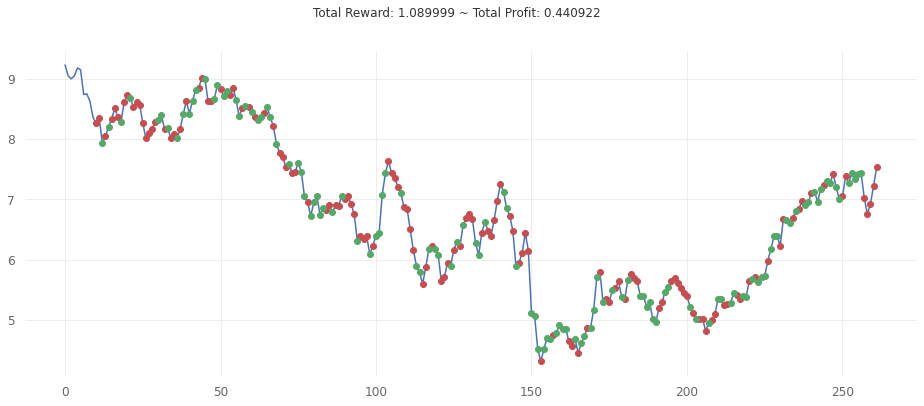

info: {'total_reward': -0.840001106262207, 'total_profit': 0.38681138399979326, 'position': 1}


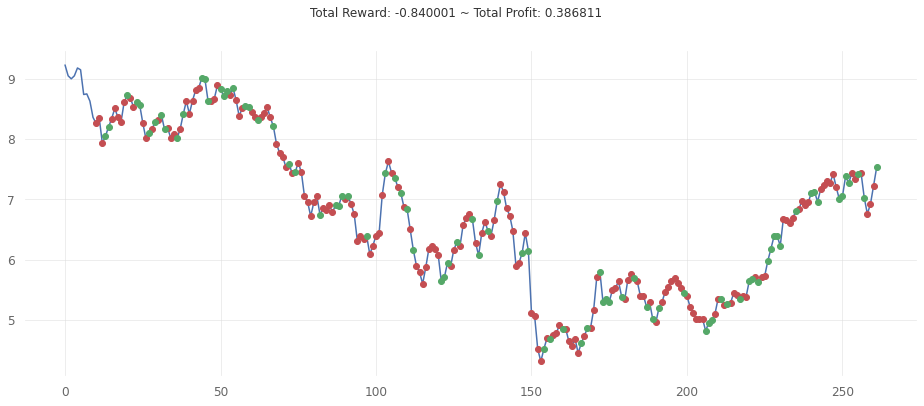

info: {'total_reward': -1.4900007247924805, 'total_profit': 0.27815526253375156, 'position': 0}


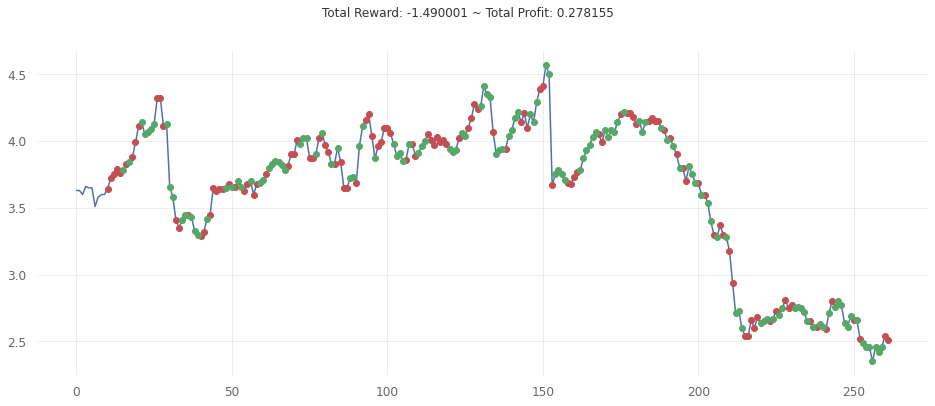

info: {'total_reward': -1.1700012683868408, 'total_profit': 0.28158899706272195, 'position': 1}


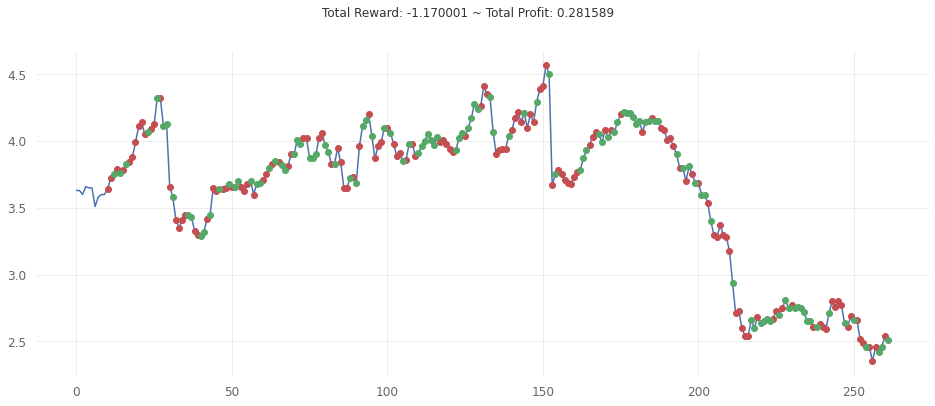

info: {'total_reward': 3.6500004529953003, 'total_profit': 0.6685772875565008, 'position': 0}


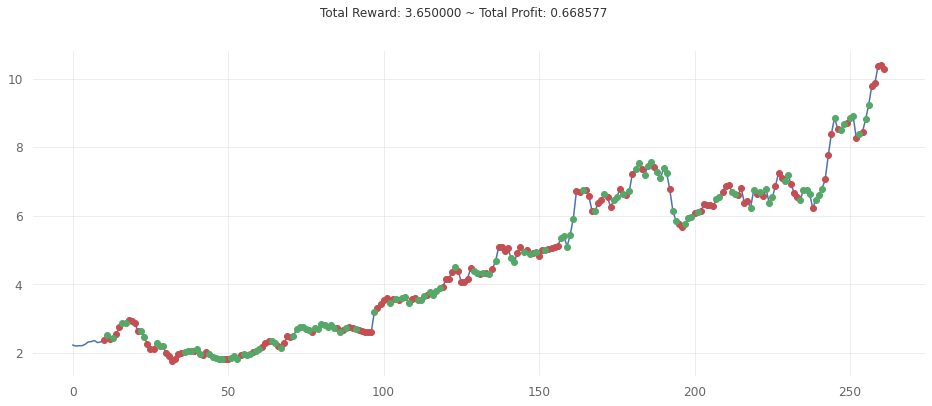

info: {'total_reward': 4.890001177787781, 'total_profit': 1.0477563671769952, 'position': 0}


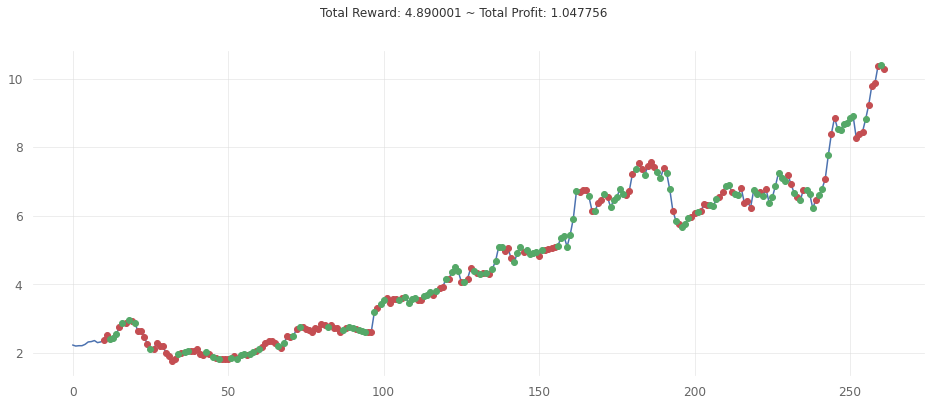






info: {'total_reward': -0.18999958038330078, 'total_profit': 0.8411242488903392, 'position': 1}


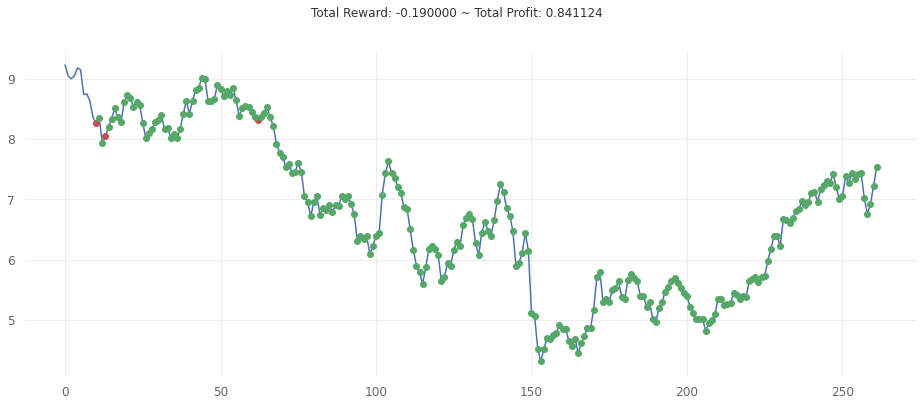

info: {'total_reward': -0.049999237060546875, 'total_profit': 0.8867181080906168, 'position': 0}


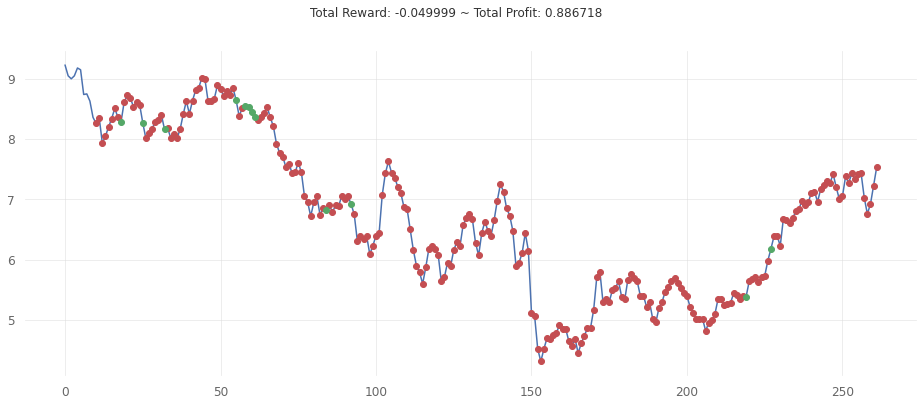

info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': 0}


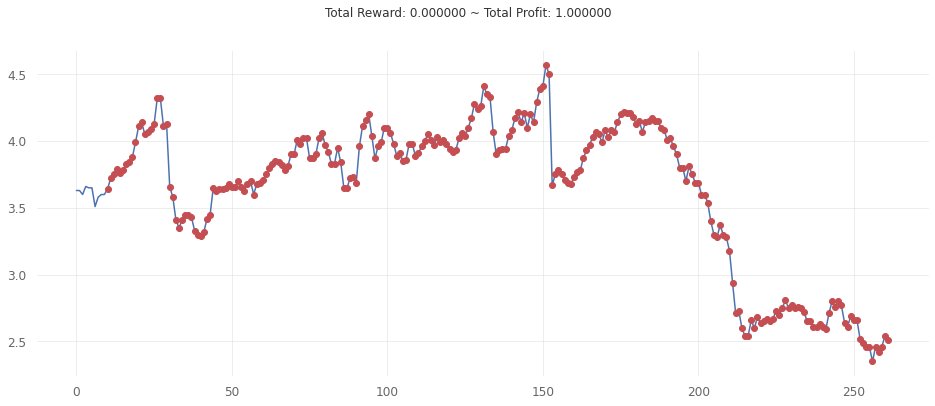

/home/m73/miniconda3/envs/py37/lib/python3.7/site-packages/quantstats/stats.py:216: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / returns.std()
/home/m73/miniconda3/envs/py37/lib/python3.7/site-packages/quantstats/stats.py:308: RuntimeWarning: invalid value encountered in double_scalars
  return cagr(returns) / exposure(returns)


info: {'total_reward': 0.19000005722045898, 'total_profit': 0.58709800852131, 'position': 1}


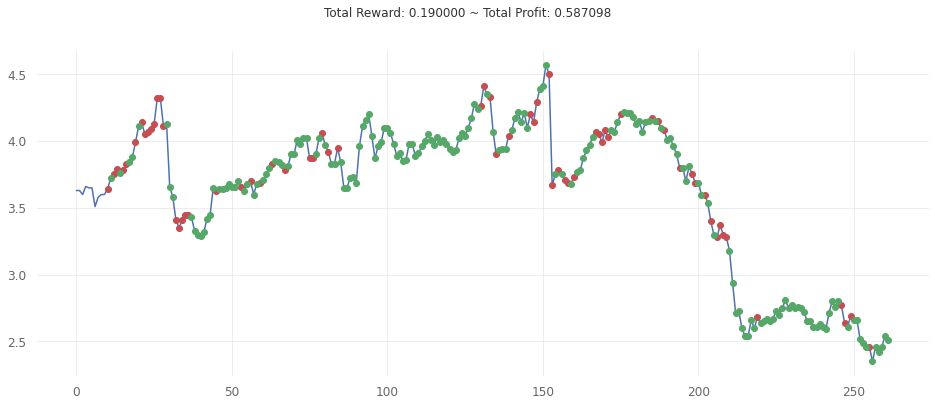

info: {'total_reward': 1.9200003147125244, 'total_profit': 1.9041142407958223, 'position': 1}


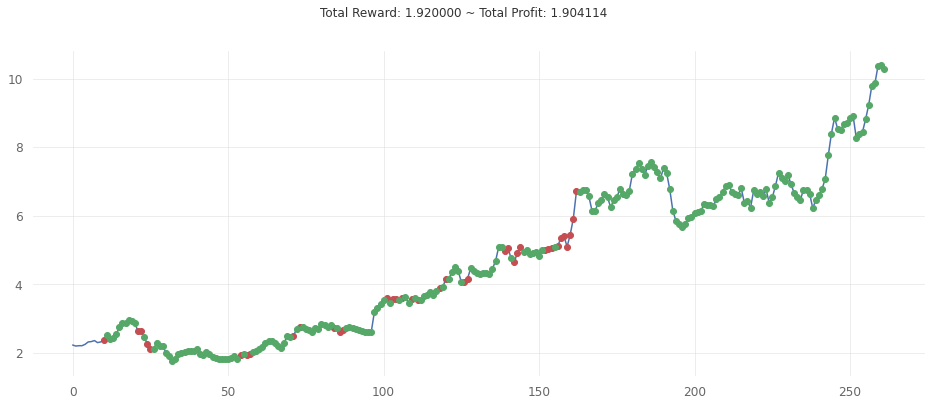

info: {'total_reward': 0.09000027179718018, 'total_profit': 1.053375446771846, 'position': 1}


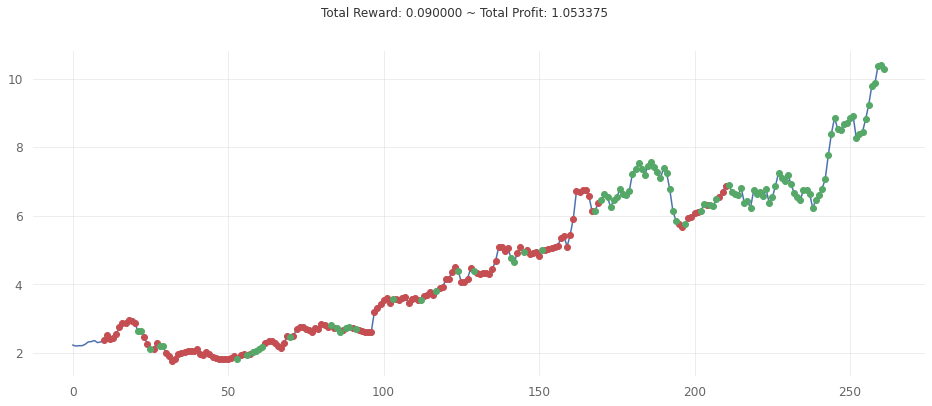

info: {'total_reward': 5.559993743896484, 'total_profit': 0.53319203751755, 'position': 1}


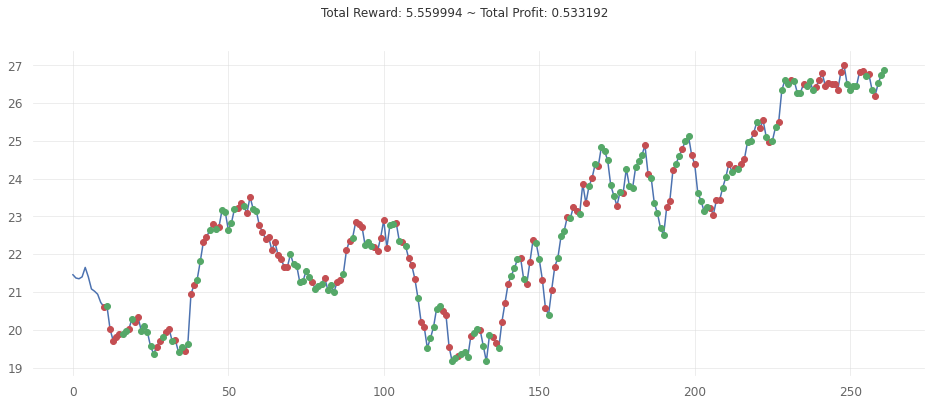

info: {'total_reward': 5.269998550415039, 'total_profit': 0.5685816947633144, 'position': 0}


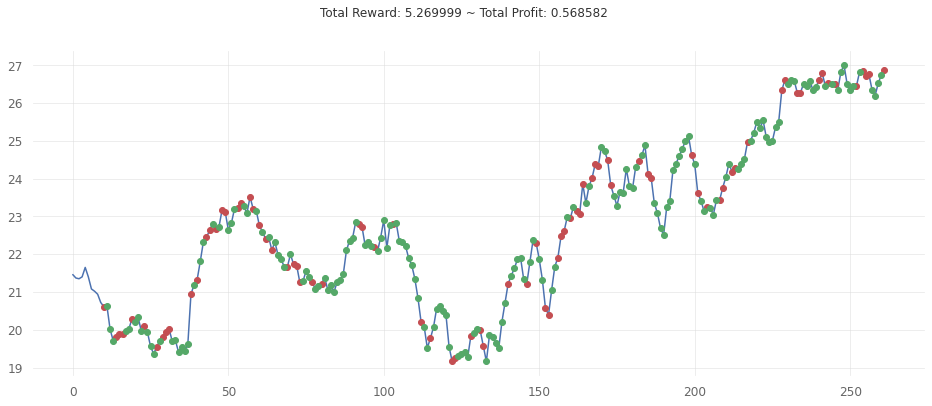

info: {'total_reward': 9.349985122680664, 'total_profit': 0.503048458260029, 'position': 0}


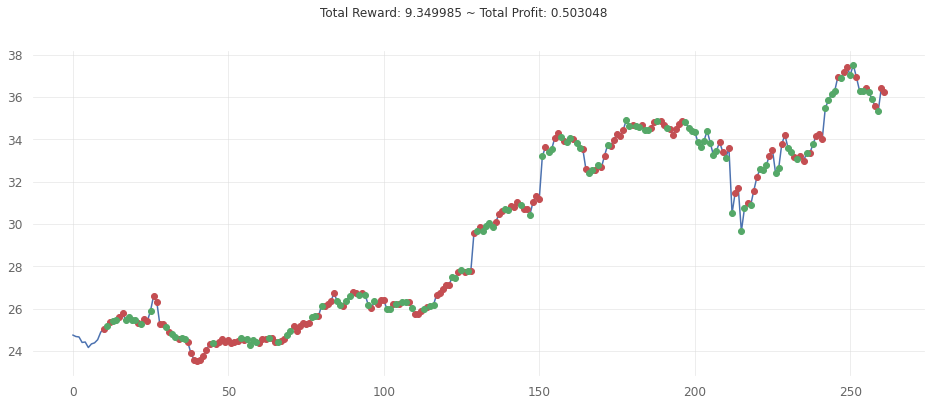

info: {'total_reward': 0.42000389099121094, 'total_profit': 0.3796254369625978, 'position': 1}


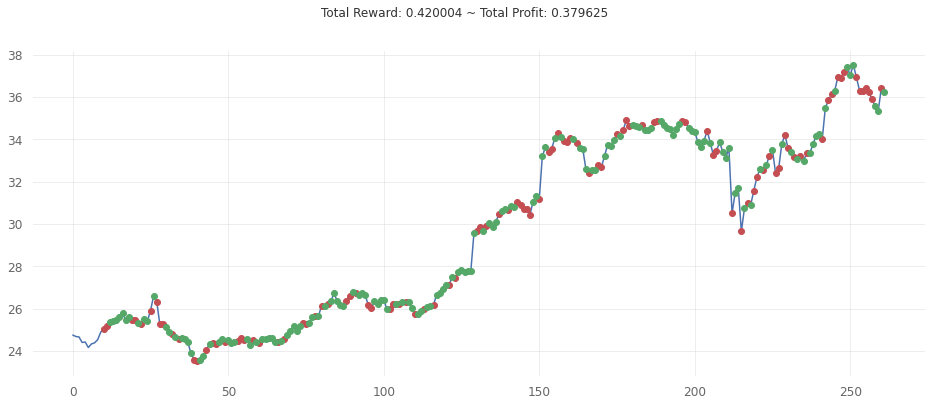

info: {'total_reward': 6.820011138916016, 'total_profit': 0.5418660362644127, 'position': 0}


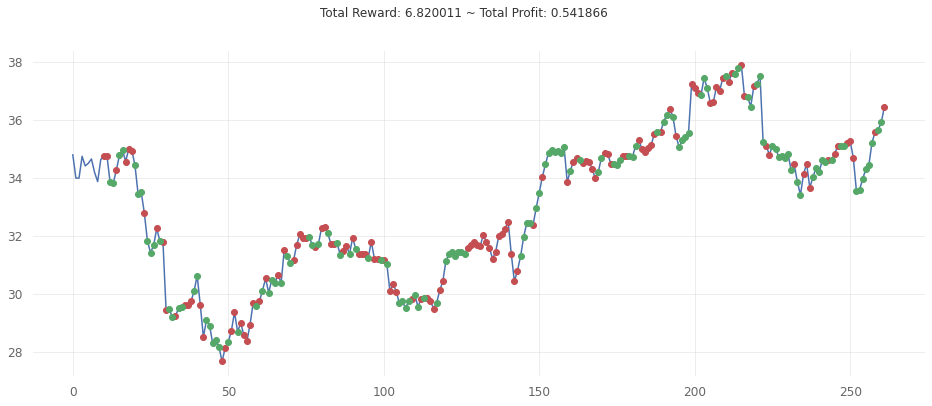

info: {'total_reward': 4.560018539428711, 'total_profit': 0.4607040616610733, 'position': 0}


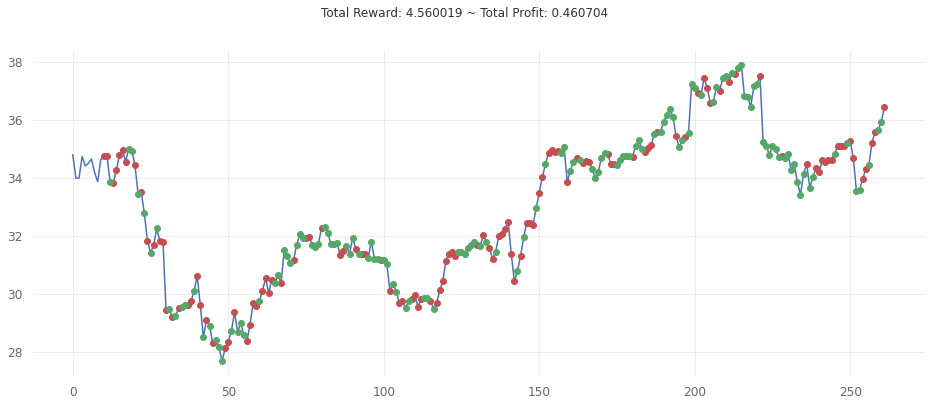

info: {'total_reward': 0.009998321533203125, 'total_profit': 1.2724505134800754, 'position': 1}


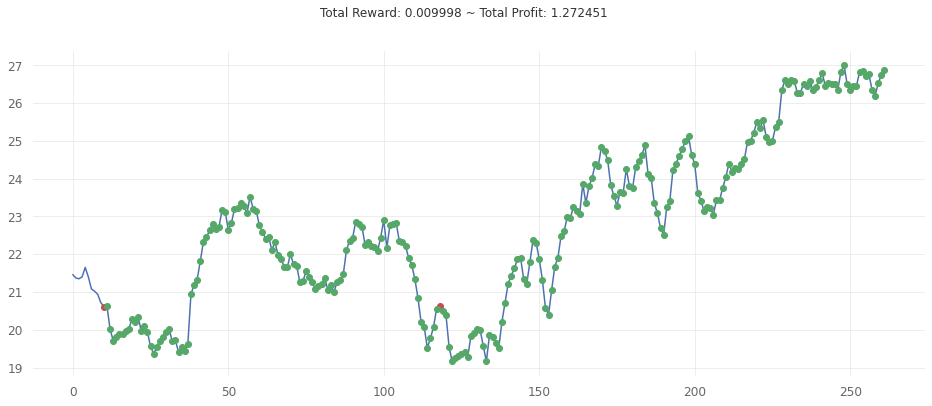

info: {'total_reward': 0.23000717163085938, 'total_profit': 0.6282414388317222, 'position': 1}


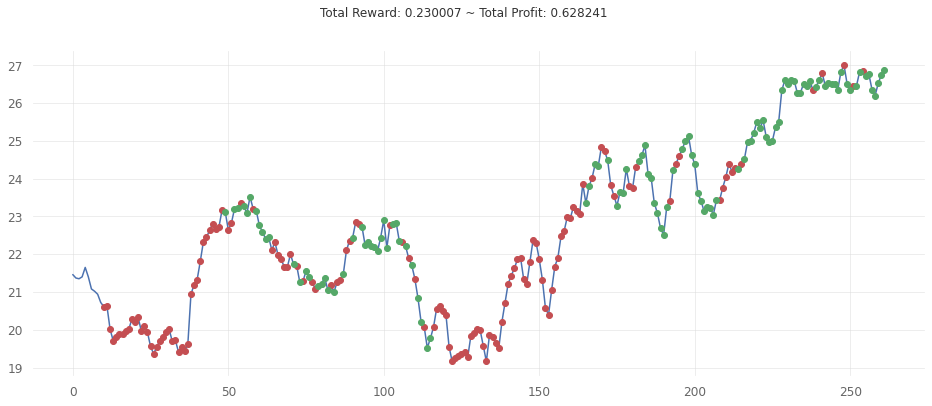

info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': 0}


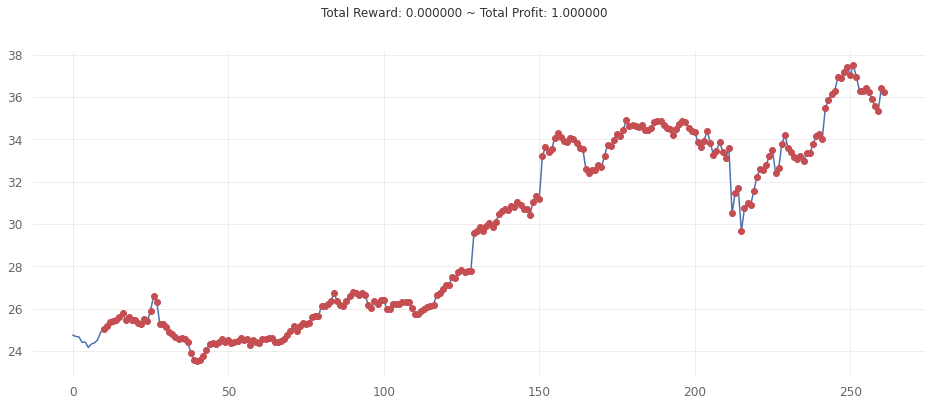

/home/m73/miniconda3/envs/py37/lib/python3.7/site-packages/quantstats/stats.py:216: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / returns.std()
/home/m73/miniconda3/envs/py37/lib/python3.7/site-packages/quantstats/stats.py:308: RuntimeWarning: invalid value encountered in double_scalars
  return cagr(returns) / exposure(returns)


info: {'total_reward': 7.399995803833008, 'total_profit': 0.8642446918192122, 'position': 1}


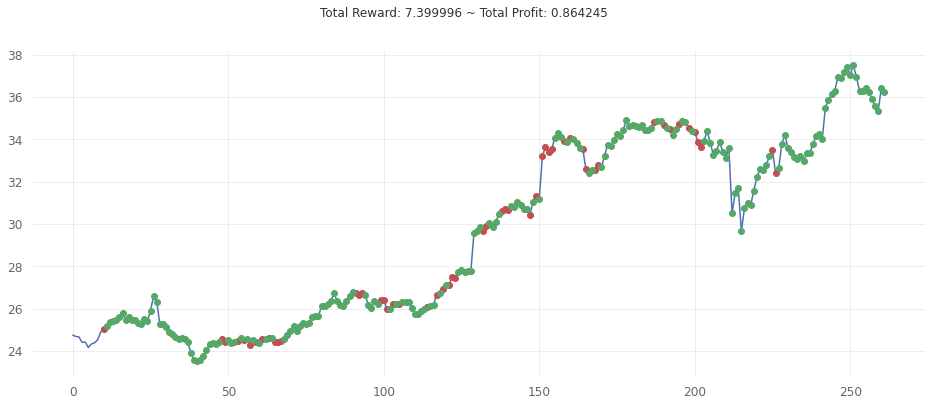

info: {'total_reward': 0.0, 'total_profit': 1.033225656858307, 'position': 1}


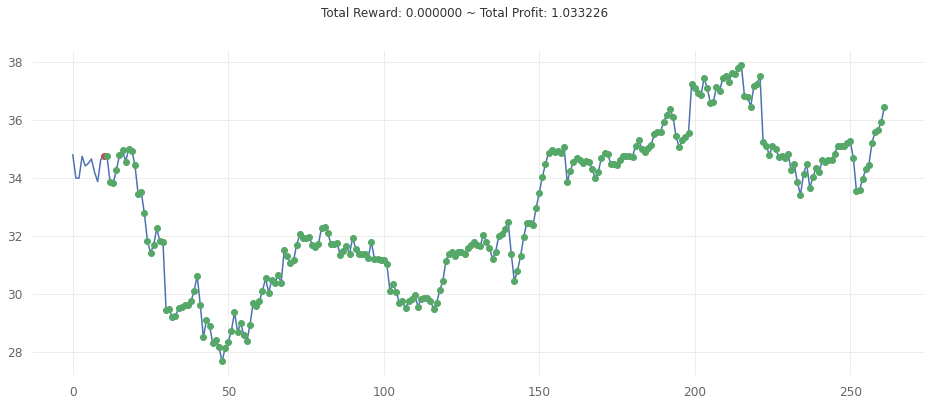

info: {'total_reward': 0.0, 'total_profit': 1.033225656858307, 'position': 1}


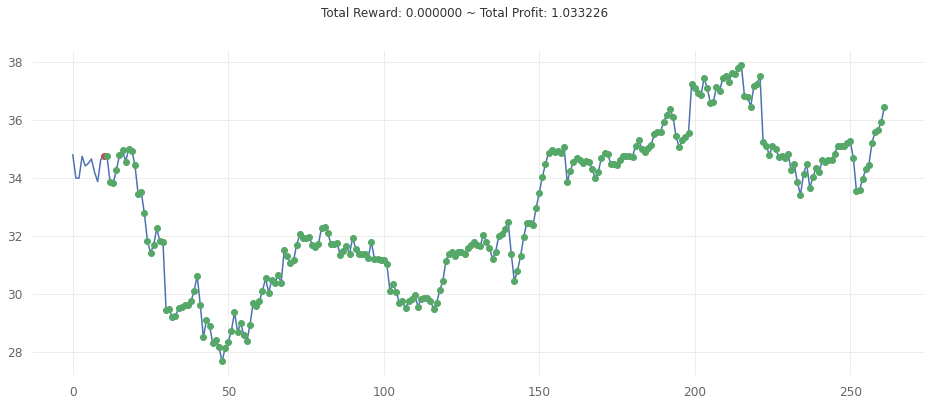

info: {'total_reward': 1.0599994659423828, 'total_profit': 0.45175025369454735, 'position': 0}


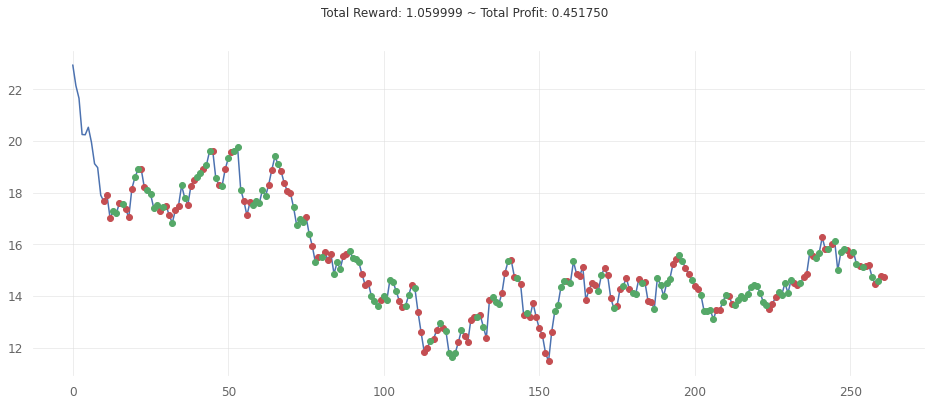

info: {'total_reward': -3.3000001907348633, 'total_profit': 0.339701932686462, 'position': 0}


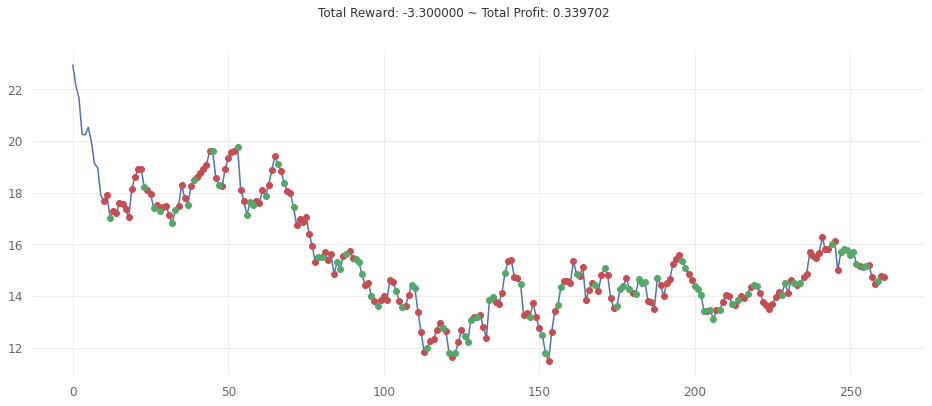

info: {'total_reward': 0.9799947738647461, 'total_profit': 0.3991927394496431, 'position': 0}


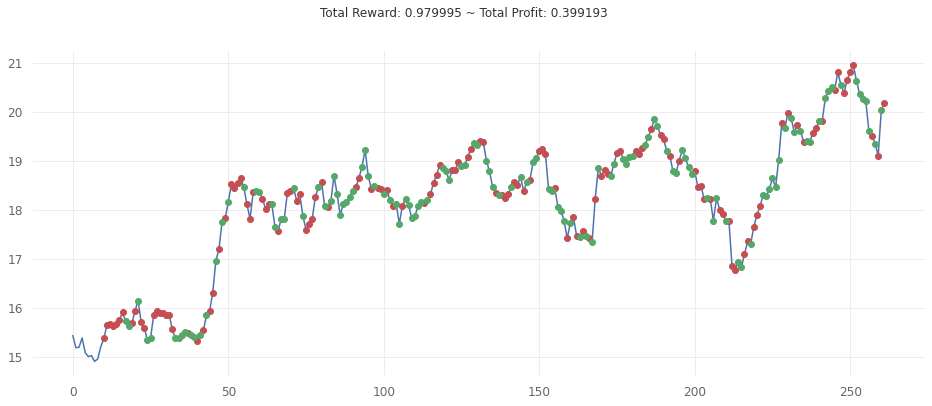

info: {'total_reward': 0.36000823974609375, 'total_profit': 0.4284798733850236, 'position': 1}


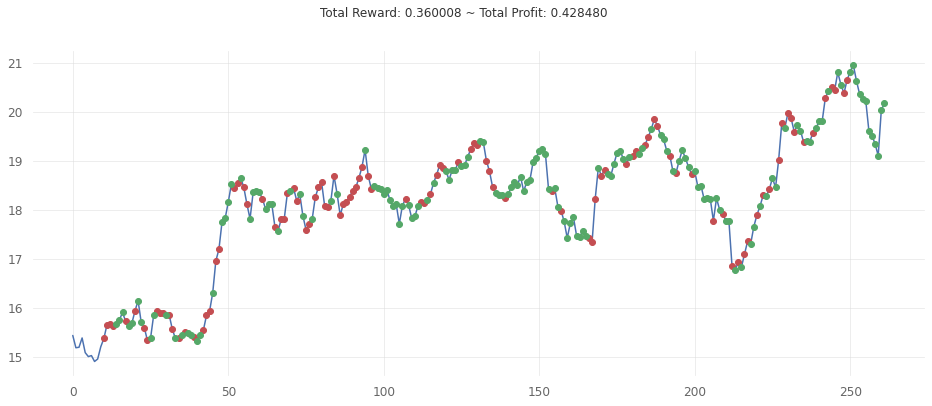

info: {'total_reward': 40.10000038146973, 'total_profit': 0.6862206734262455, 'position': 1}


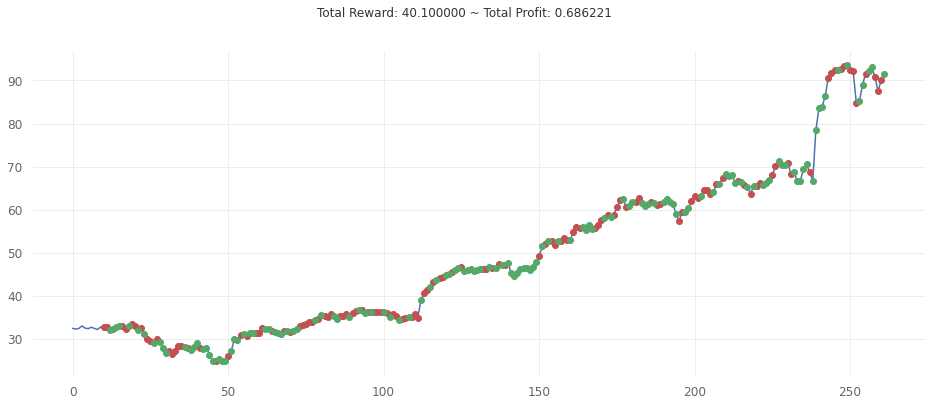

info: {'total_reward': 32.679996490478516, 'total_profit': 0.6962359068262473, 'position': 1}


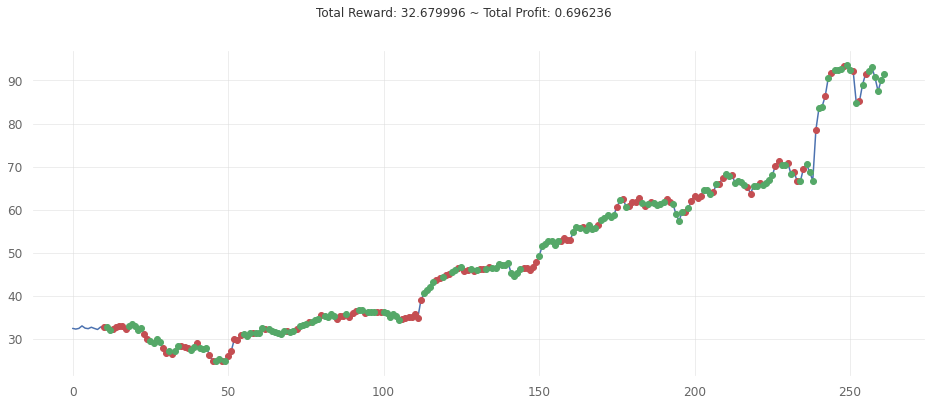

info: {'total_reward': -3.119997024536133, 'total_profit': 0.5947870970533621, 'position': 0}


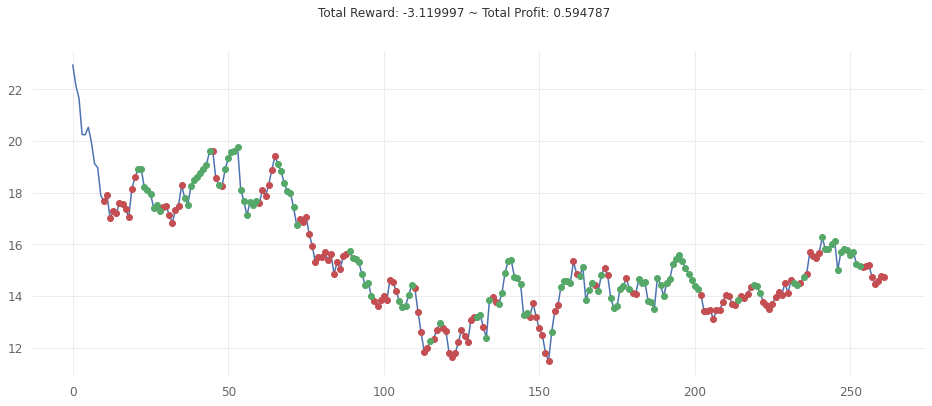

info: {'total_reward': -0.2500009536743164, 'total_profit': 0.6300393922692848, 'position': 1}


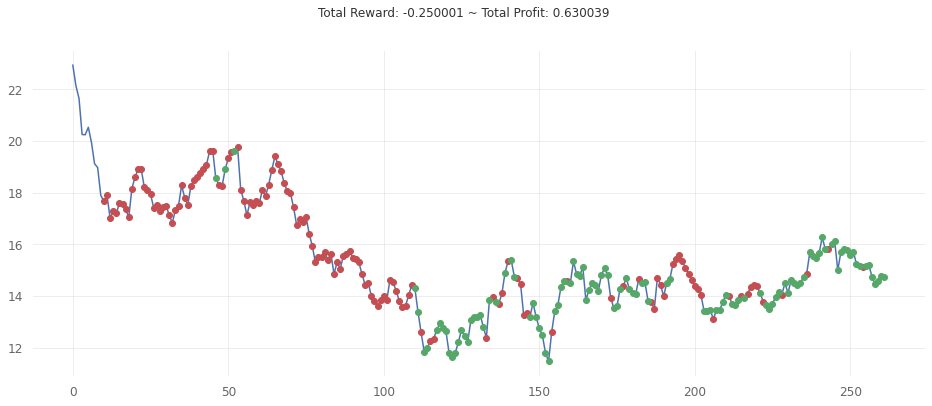

info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': 0}


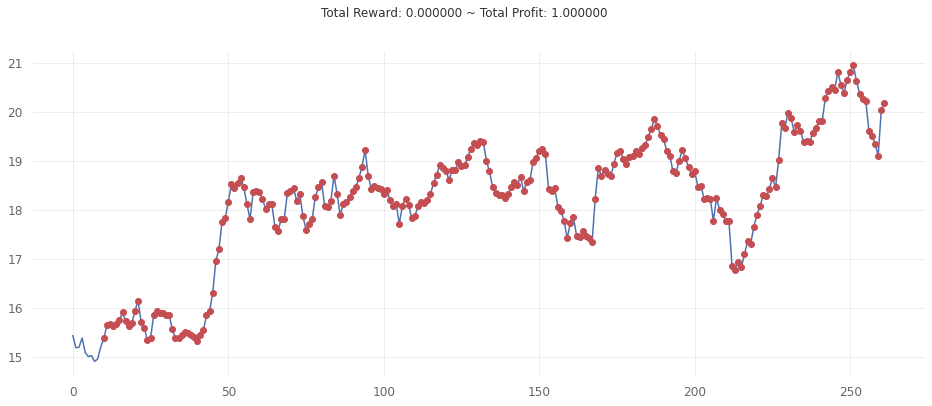

/home/m73/miniconda3/envs/py37/lib/python3.7/site-packages/quantstats/stats.py:216: RuntimeWarning: invalid value encountered in double_scalars
  res = returns.mean() / returns.std()
/home/m73/miniconda3/envs/py37/lib/python3.7/site-packages/quantstats/stats.py:308: RuntimeWarning: invalid value encountered in double_scalars
  return cagr(returns) / exposure(returns)


info: {'total_reward': 0.8199901580810547, 'total_profit': 0.49705009483030704, 'position': 1}


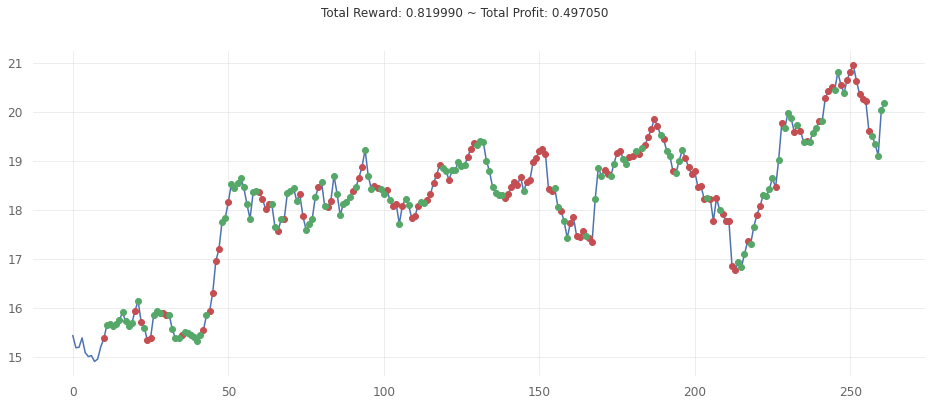

info: {'total_reward': 11.140003204345703, 'total_profit': 2.543457902755373, 'position': 1}


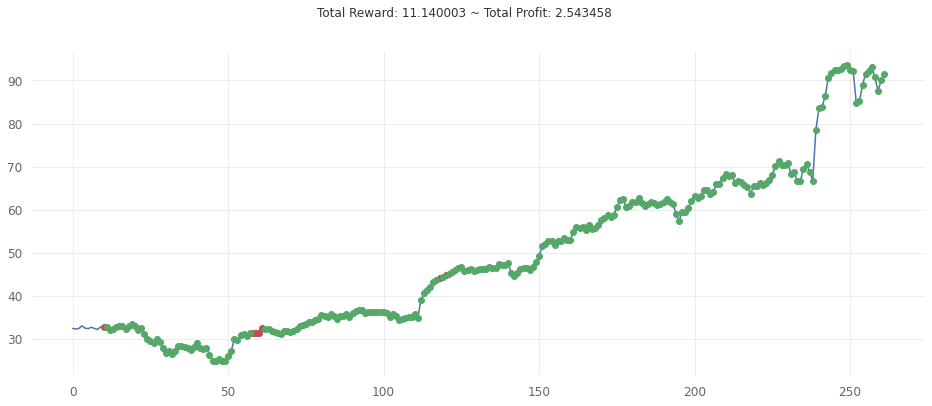

info: {'total_reward': -4.829999923706055, 'total_profit': 2.2307144543554394, 'position': 1}


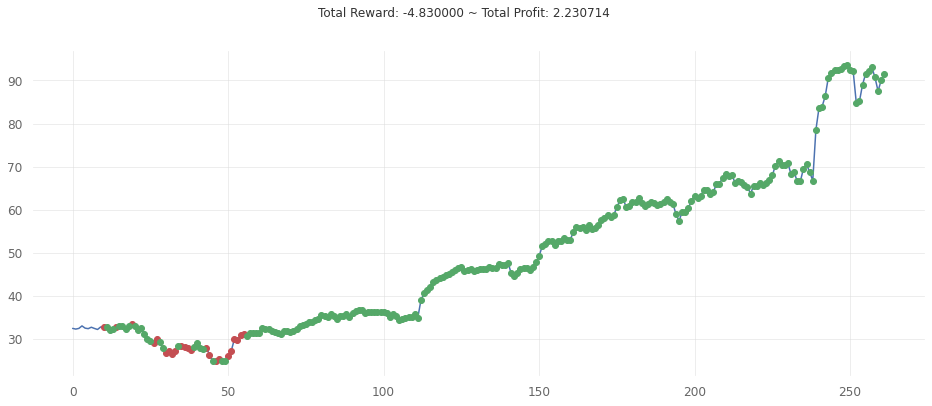

In [14]:
for stock_idx, stock in enumerate(stocks):
    for algo_idx, algo in enumerate(algos):
        for day_idx, end_index in enumerate(days):
            for step_idx, steps in enumerate([1000, 10000]):
                #make env
                #(our custom env)
                env2 = MyCustomEnv(df=stock, window_size=window_size, frame_bound=(start_index,end_index))
                env_maker = lambda: env2

                #default environment
                #env_maker = lambda: gym.make('stocks-v0', df=amd, frame_bound=(start_index, end_index), window_size=window_size)
                env = DummyVecEnv([env_maker])
                
                #A2C
                if algo_idx == 0:
                    #train env
                    model = algo(env, MlpLstmPolicy)
                    model.learn(total_timesteps=steps)
                #DQN
                elif algo_idx == 1:
                    #train env
                    model = algo(env, dqnpol)
                    model.learn(total_timesteps=steps)
                #DDPG
                elif algo_idx == 2:
                    # the noise objects for DDPG
                    n_actions = env.action_space.shape[-1]
                    param_noise = None
                    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))
                    model = algo(env, ddpgpol, param_noise, action_noise)

                #test env
                env2 = MyCustomEnv(df=stock, window_size=window_size, frame_bound=(end_index,end_index+252))
                env_maker = lambda: env2
                env = env_maker()
                observation = env.reset()

                while True:
                    observation = observation[np.newaxis, ...]
                    action, _states = model.predict(observation)
                    observation, reward, done, info = env.step(action)

                    if done:
                        print("info:", info)
                        break

                #save transaction results
#                 days = end_index
#                 fname = pathify("amd", "a2c", "mlplstm", days, steps, kind="transaction")
                
                plt.figure(figsize=(16, 6))
                env.render_all()
                plt.show()
                #env.save_rendering(fname)

                #get returns and get analysis
                qs.extend_pandas()
                net_worth = pd.Series(env.history['total_profit'], index=amd.index[end_index+1:end_index+252]) 
                #<- note the indexes are of the evaluated year                                        ^
                returns = net_worth.pct_change().iloc[1:]
                
                #fill in total data
                board = bucket[stock_idx, algo_idx, day_idx, step_idx]
                metrics = get_metrics(returns)
                board["ex_returns"] = metrics["ex_returns"]
                board["best"] = metrics["best"]
                board["worst"] = metrics["worst"]
                board["avg_returns"] = metrics["avg_returns"]
                board["vola"] = metrics["vola"]
                board["sharpe"] = metrics["sharpe"]
                board["rar"] = metrics["rar"]
                board["ror"] = metrics["ror"]
                

### Finding bests and making graphs

In [15]:
#highest
def highestof(metric, stocks, algos, days, steps):
    inds = np.unravel_index(bucket[metric].argmax(), bucket[metric].shape)
    print("Stock: ", stocks[inds[0]])
    print("Algo: ", algos[inds[1]])
    print("Days: ", days[inds[2]])
    print("Steps: ", steps[inds[3]])

#lowest
def lowestof(metric, stocks, algos, days, steps):
    inds = np.unravel_index(bucket[metric].argmin(), bucket[metric].shape)
    print("Stock: ", stocks[inds[0]])
    print("Algo: ", algos[inds[1]])
    print("Days: ", days[inds[2]])
    print("Steps: ", steps[inds[3]])


In [19]:
steps = [1000, 10000]

In [21]:
highestof("ror", tickers, algorithms, days, steps)

Stock:  amd
Algo:  dqn
Days:  300
Steps:  1000


In [20]:
lowestof("ror", tickers, algorithms, days, steps)

Stock:  intc
Algo:  dqn
Days:  1500
Steps:  1000


In [22]:
highestof("sharpe", tickers, algorithms, days, steps)

Stock:  amd
Algo:  dqn
Days:  1000
Steps:  1000


In [23]:
lowestof("sharpe", tickers, algorithms, days, steps)

Stock:  amd
Algo:  dqn
Days:  1000
Steps:  1000


In [25]:
highestof("vola", tickers, algorithms, days, steps)

Stock:  nvda
Algo:  dqn
Days:  1500
Steps:  10000


In [26]:
lowestof("vola", tickers, algorithms, days, steps)

Stock:  amd
Algo:  dqn
Days:  1000
Steps:  1000


### Plots

In [ ]:
daa = bucket["ror"][0].reshape(2,6)
daa

In [ ]:
#ror for given stock
data = daa

length = len(data)
x_labels = ['A1', "A2"]

# Set plot parameters
fig, ax = plt.subplots()
width = 0.1 # width of bar
x = np.arange(length)

ax.bar(x, data[:,0], width, color='#000080', label='300days, 100k steps')
ax.bar(x + width, data[:,1], width, color='#0F52BA', label='1000days, 100k steps')
ax.bar(x + (2 * width), data[:,2], width, color='#6593F5', label='1500days, 100k steps')
ax.bar(x + (3 * width), data[:,3], width, color='#73C2FB', label='300days, 1mn steps')
ax.bar(x + (3 * width), data[:,4], width, color='#73C2FB', label='1000days, 1mn steps')
ax.bar(x + (3 * width), data[:,5], width, color='#73C2FB', label='1500days, 1mn steps')

ax.set_ylabel('Metric')
ax.set_ylim(0,1)
ax.set_xticks(x + width + width/2)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Scenario')
ax.set_title('Title')
ax.legend()
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()